# Chapter 3. Classification

## MNIST
Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents.

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print('X size', X.shape)
print('label size:', y.shape)

X size (70000, 784)
label size: (70000,)


There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s `imshow()` function:

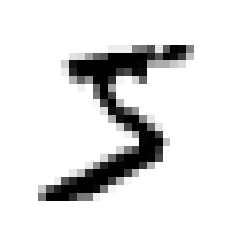

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values
some_digits_image = some_digit.reshape(28, 28)

plt.imshow(some_digits_image, cmap='binary')
plt.axis("off")
plt.show()

In [4]:
print(y[0])

5


In [5]:
# Let's cast labels as integers
import numpy as np

y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's try to identify only one digit "5". This will be an example of _binary classifier_, capable of distibuishing between just two classes, 5 and not-5.

In [7]:
# Set for all 5s
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a _Stochastic Gradient Descent (SGD)_ classifier. This classifier deals with large datasets efficiently, because it deals with training instances independetly, one at a time.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Predicting if the digit is 5
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation
Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluatingthem on each fold using a model trained on the remaining folds.

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

before we get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [10]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with _skewed datasets_.

### Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. The `cross_val_predict()`
performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set.

In [11]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Let's get the confusion matrix and pass the target classes and the predicted classes

In [12]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an _actual class_, while each column represents a _predicted class_. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives), while the remaining 3,530 were correctly classified as 5s (true positives).

An interesting one to look at the accuracy of the positive predictions; this is called the precision of the classifier. _precision_= $\frac{TP}{TP+FP}$. The $TP$ is the number of true positives, and $FP$ is the number of false positives.

precision is typically used along with another metric named _recall_, also called sensitivity or the true positive rate (TPR): this is the ratio of positive instances that are correctly detected by the classifier. _recall_=$\frac{TP}{TP+FN}$. $FN$ is the number of false negatives.

### Precision and Recall

In [13]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [14]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the $F_1$ score, in particular if you need a simple way to compare two 
classifiers. The $F_1$ score is the harmonic mean of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.

$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}=\frac{TP}{TP+\frac{FN+FP}{2}}$

In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The $F_1$ score favors classifiers that have similar precision and recall. This
is not always what you want: in some contexts you mostly care about
precision, and in other contexts you really care about recall. For example,
if you trained a classifier to detect videos that are safe for kids, you would
probably prefer a classifier that rejects many good videos (low recall) but
keeps only safe ones (high precision), rather than a classifier that has a
much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to
check the classifier’s video selection). On the other hand, suppose you
train a classifier to detect shoplifters in surveillance images: it is probably
fine if your classifier has only 30% precision as long as it has 99% recall
(sure, the security guards will get a few false alerts, but almost all
shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces
recall, and vice versa. This is called the precision/recall trade-off.

How to decide which threshold to use for **SGDClassifier**? First, use the `cross_val_predict()` function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, 
                            cv=3, method='decision_function')

compute precision and recall for all possible thresholds:

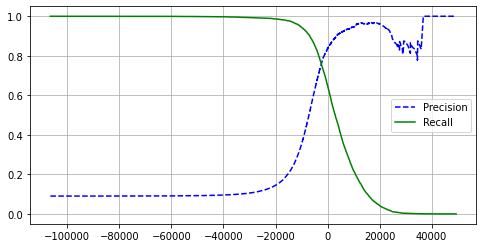

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8,4))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.grid(axis='both')
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Suppose you decide to aim for 90% precision. You look up the first plot
and find that you need to use a threshold of about 8,000. To be more
precise you can search for the lowest threshold that gives you at least 90%
precision ( `np.argmax()` will give you the first index of the maximum
value, which in this case means the first `True` value).

In [19]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

# Now let's make prediction with this threshold
y_train_pred_90 = (y_scores >= threshold_90_precision)

print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))

Precision: 0.9000345901072293
Recall: 0.4799852425751706


A high-precision classifier is not very useful if its recall is too low!

### The ROC Curve
The _receiver operating characteristic (ROC)_ curve is another common
tool used with binary classifiers. It is very similar to the precision/recall
curve, but instead of plotting precision versus recall, the ROC curve plots
the true positive rate (another name for recall) against the false positive
rate (FPR). The FPR is the ratio of negative instances that are incorrectly
classified as positive. It is equal to 1 – the true negative rate (TNR), which
is the ratio of negative instances that are correctly classified as negative.
The TNR is also called specificity. Hence, the ROC curve plots sensitivity
(recall) versus 1 – specificity

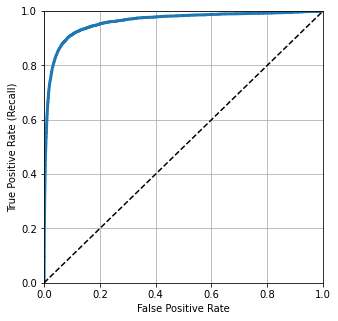

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

# Plot FPR against the TPR
def plot_roc_curve(fpr, tpr, label=None):
    """Plots ROC Curve (FPR agains TPR)"""
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, linewidth=3, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid(axis='both')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlabel('False Positive Rate')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve
(AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a
purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn
provides a function to compute the ROC AUC:

In [21]:
from sklearn.metrics import roc_auc_score

print('ROC AUC Score:', roc_auc_score(y_train_5, y_scores))

ROC AUC Score: 0.9604938554008616


As a rule of thumb, you should prefer the PR curve
whenever the positive class is rare or when you care more about the false positives
than the false negatives. Otherwise, use the ROC curve.

In [22]:
# Let's train random forest model
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                 method='predict_proba')

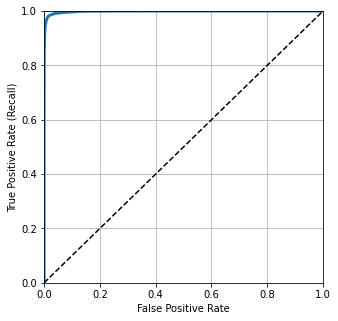

In [23]:
# The roc_curve() function expects labels and scores, 
# but instead of scores you can give it class probabilities
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

In [24]:
print('ROC AUC score:', roc_auc_score(y_train_5, y_scores_forest))

ROC AUC score: 0.9983436731328145


You now know how to train binary classifiers, choose the appropriate
metric for your task, evaluate your classifiers using cross-validation,
select the precision/recall trade-off that fits your needs, and use ROC
curves and ROC AUC scores to compare various models.

## Multiclass Classification
_Multinomial classifier_ distinguishes between more than two classes. Even though some algorithms only perform binary classifications, there are ways to still use them for multiple classes classification. One way is to create a system that classifies 10 different type images by taking one class at a time and classifying it against the rest. This is called _one-versus-rest_ (OvR) strategy. Another strategy is to train a binary classifier for every pair of classes: distinguish between 0 and 1 class, then between 0 and 2, then between 0 and 3 and so on. This is called _one-versus-one_ (OvO) strategy. For $N$ classes you need to train $\frac{N\times (N-1)}{2}$ classifiers.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm:

In [25]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

This code trains the SVC on the training set using the original target classes from 0 to 9 ( y_train ), instead of the 5-versus-the-rest target classes ( y_train_5 )

In [26]:
# This will return 10 scores per instance
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [27]:
# Highest score is the one corresponding to class 5
np.argmax(some_digit_scores)

5

In [28]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [29]:
svm_clf.classes_[5]

5

**WARNING**: When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value.

If you want to force Scikit-Learn to use _one-versus-one_ or _one-versus-the-rest_, you can use the `OneVsOneClassifier` or `OneVsRestClassifier` classes

In [30]:
# Classify using OvR
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [31]:
len(ovr_clf.estimators_)

10

In [32]:
# Trying SGD Classifier. No need for OvR or OvO as
# SGD directly classifies into multiple classes.
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [33]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

You can see that the classifier is fairly confident about its prediction: almost all scores are largely negative, while class 5 has a score of ...

You can evaluate this classifier using `cros_val_score()`.

In [34]:
cross_val_score(sgd_clf, X_train, y_train,
                cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

We get 86% on all test folds. If we used a random classifier we would get 10%. We still can get a better score by scaling the inputs:

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis

One way to improve selected model is to analyze the types of errors it makes.

In [37]:
# Let's look at the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[5577    0   22    5    8   43   36    6  225    1]
 [   0 6400   37   24    4   44    4    7  212   10]
 [  27   27 5220   92   73   27   67   36  378   11]
 [  22   17  117 5227    2  203   27   40  403   73]
 [  12   14   41    9 5182   12   34   27  347  164]
 [  27   15   30  168   53 4444   75   14  535   60]
 [  30   15   42    3   44   97 5552    3  131    1]
 [  21   10   51   30   49   12    3 5684  195  210]
 [  17   63   48   86    3  126   25   10 5429   44]
 [  25   18   30   64  118   36    1  179  371 5107]]


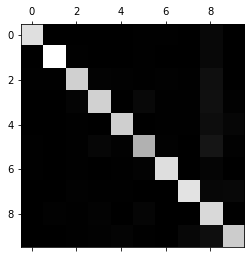

In [61]:
# Let's look ath the image of the confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

The 5s look slightly darker than the other digits, which could mean that there are
fewer images of 5s in the dataset or that the classifier does not perform as
well on 5s as on other digits. In fact, you can verify that both are the case.

Let’s focus the plot on the errors. First, you need to divide each value in
the confusion matrix by the number of images in the corresponding class
so that you can compare error rates instead of absolute numbers of errors:

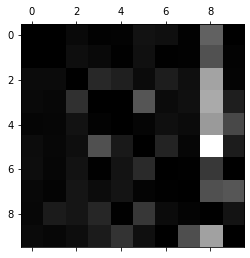

In [60]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Analyzing individual errors can also be a good way to gain insights on
what your classifier is doing and why it is failing, but it is more difficult
and time-consuming. For example, let's ploit 3s and 5s:

In [78]:
def plot_digits(instances, images_per_row=10, **options):
    """
    Plots digit with a grid form - correctly & incorrecly guessed
    """
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances.values]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

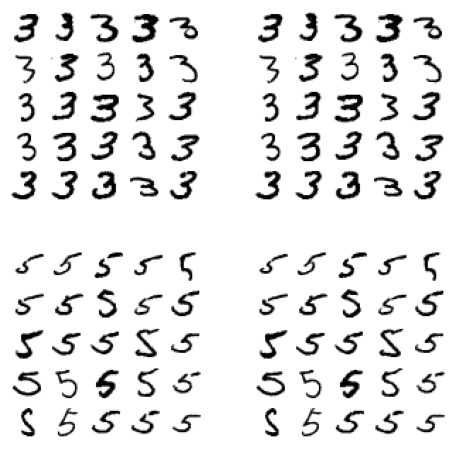

In [79]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. 3 The reason is that we used a simple `SGDClassifier`, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixelintensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction
slightly shifted to the left, the classifier might classify it as a 5, and vice versa. In other words, this classifier is quite sensitive to image shifting and rotation. So one way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated. This will probably help reduce other errors as well.

## Multilabel Classification

Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie. Then when the classifier is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning “Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple binary tags is called _a multilabel classification_ system.

In [81]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8,or 9), and the second indicates whether or not it is odd.

In [83]:
# Prediction with Multilabel classifier
knn_clf.predict([some_digit])

array([[False,  True]])

And it gets it right! The digit 5 is indeed not large ( False ) and odd ( True ).

One approach to evaluate multilable classifier is to measure $F_1$ score for each individual label, then compare the average score.

In [85]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

If for example we have many more pictures of Alice then of Bob or Charlie, you may want to give more weight to the classifier's score on picture of Alice. Simple option is to give each label a weight equal to its support. This can be done by setting `average="weighted"`.

## Multioutput Classification

Multiclass or multioutput classification can have more than two possible values.

Let's first build a system that removes noise from images. The classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255).

In [94]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

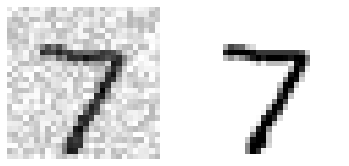

In [98]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
# Let's take a look at the example
some_index = 0
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index].values)
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index].values)
plt.show()

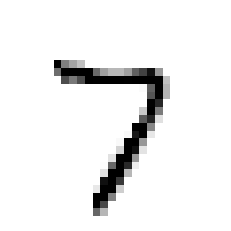

In [101]:
# Let's run the classifier
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index].values])
plot_digit(clean_digit)

Looks close enough to the target! This concludes our tour of classification.